# Importing libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import RFECV
from yellowbrick.regressor import ManualAlphaSelection
from yellowbrick.regressor import AlphaSelection
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import learning_curve 

sns.set()

# Loading the dataset

In [2]:
current_dir = os.getcwd()
train_file_path = os.path.join(current_dir, 'CMAPSSData/train_FD001.txt')
test_file_path = os.path.join(current_dir, 'CMAPSSData/test_FD001.txt')
RUL_file_path = os.path.join(current_dir, 'CMAPSSData/RUL_FD001.txt')

In [3]:
column_names = ['unit_no', 'cycles', 'setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]

features_names = column_names + sensor_names

In [4]:
train = pd.read_csv(train_file_path, sep='\s+', header = None, names = features_names)
test = pd.read_csv(test_file_path, sep='\s+', header = None, names = features_names)
y_test = pd.read_csv(RUL_file_path, sep='\s+', header=None, names = ['RUL'])

In [5]:
sensors_to_drop = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
labels_to_drop = column_names + sensors_to_drop

# Utility functions

In [6]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_pred)
    print('RMSE : {} and R2 : {}'.format(rmse, variance))
    
def evaluate_train_test(model, X_train, y_train, X_test, y_test):
    print('Training_performance')
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    evaluate_model(y_train, y_pred_train)
    print('\nTesting_performance')
    y_pred_test = model.predict(X_test)
    evaluate_model(y_test, y_pred_test)

In [7]:
def plot_learning_curves(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train_errors, test_errors = [], []
    for m in range(1, len(X_train), 500):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_test_pred = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))
    plt.plot(-np.sqrt(train_errors), label="train")
    plt.plot(-np.sqrt(test_errors), label="test")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc="upper right", fontsize=14)
    plt.title("Learning curves")

In [8]:
def visualiser_learning_curve(model, model_name, X_train, y_train, path): 
    visualizer = LearningCurve(model, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    visualizer.fit(X_train, y_train)     
    visualizer.finalize()

    visualizer.ax.set_title('Learning curve for ' + model_name)
    visualizer.ax.set_ylabel('Neg RMSE')

    plt.savefig(os.path.join("model_figs", path))
    plt.show();

In [9]:
def visualiser_pred_error(model, model_name, X_train, y_train, X_test, y_test, path):
    plt.clf()
    visualizer = PredictionError(model, bestfit=False)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)

    visualizer.finalize()

    visualizer.ax.set_title('Prediction Error for ' + model_name)
    visualizer.ax.set_xlabel('Actual RUL')
    visualizer.ax.set_ylabel('Predicted RUL')

    plt.savefig(os.path.join("model_figs", path))
    plt.show();

In [10]:
def append_rul(df):
    df_by_unit_no = df.groupby('unit_no')
    max_nb_cycles = pd.DataFrame(df_by_unit_no['cycles'].max()).rename(columns={'cycles': 'max_cycles'})
    output = df.merge(max_nb_cycles, how = 'inner', on = 'unit_no')
    output['RUL'] = output['max_cycles'] - output['cycles']
    output = output.drop(columns=['max_cycles'])
    return output

train = append_rul(train)

# Pipeline

In [11]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Train/test sets

In [12]:
X_train = train.drop(labels_to_drop, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125).values.reshape(-1)
y_train = y_train.values.reshape(-1)

X_test = test.groupby('unit_no').last().reset_index().drop(labels_to_drop, axis=1).values
y_test = y_test.values.reshape(-1)

# Linear Regression

In [13]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

In [14]:
evaluate_train_test(linear_model, X_train, y_train, X_test, y_test)

Training_performance
RMSE : 44.668191595454324 and R2 : 0.5794486527796754

Testing_performance
RMSE : 31.952633027741896 and R2 : 0.40877368076573795


In [26]:
visualizer = ResidualsPlot(linear_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show(outpath='model_figs/linear_reg/residuals_linear_reg.png');

In [27]:
visualizer = ResidualsPlot(linear_model, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show(outpath='model_figs/linear_reg/residuals_linear_reg_qqplot.png');

In [28]:
# Instantiate RFECV visualizer with a linear regression
visualizer = RFECV(linear_model)
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show(outpath='model_figs/linear_reg/rfecv_linear_reg.png');           # Finalize and render the figure

In [29]:
visualizer = PredictionError(linear_model, bestfit=False)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(outpath='model_figs/linear_reg/pred_linear_reg.png');                 # Finalize and render the figure

# Ridge Regression (L2 reg)

In [30]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

evaluate_train_test(ridge_model, X_train, y_train, X_test, y_test)

Training_performance
RMSE : 44.668199947504846 and R2 : 0.5794484955104287

Testing_performance
RMSE : 31.953934740677017 and R2 : 0.40872550804563024


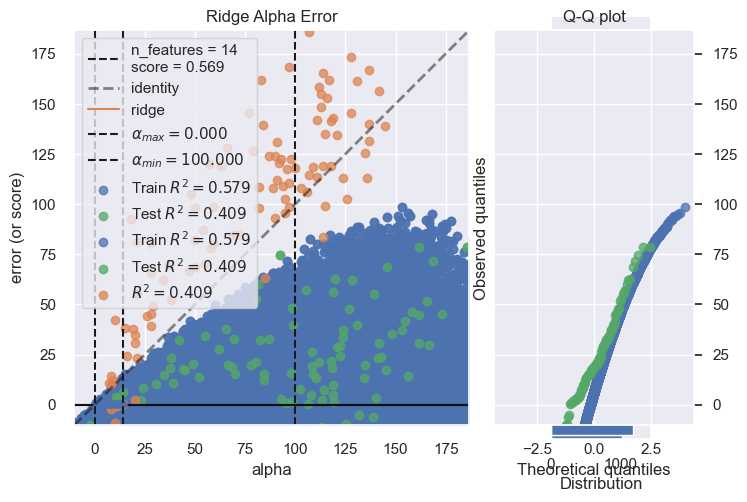

In [31]:
list_alpha = np.arange(0, 101, 10)

visualizer = ManualAlphaSelection(ridge_model, alphas=list_alpha, cv=10, scoring="neg_root_mean_squared_error")
visualizer.fit(X_train, y_train)
visualizer.show();

## GridSearchCV

In [32]:
params_dict = {
    "alpha": [0, 0.1, 1, 5, 10, 20, 30, 40]
}

grid_ridge = GridSearchCV(ridge_model, param_grid=params_dict, scoring='neg_root_mean_squared_error', cv=3)
grid_ridge.fit(X_train, y_train)
grid_ridge.best_params_

{'alpha': 0.1}

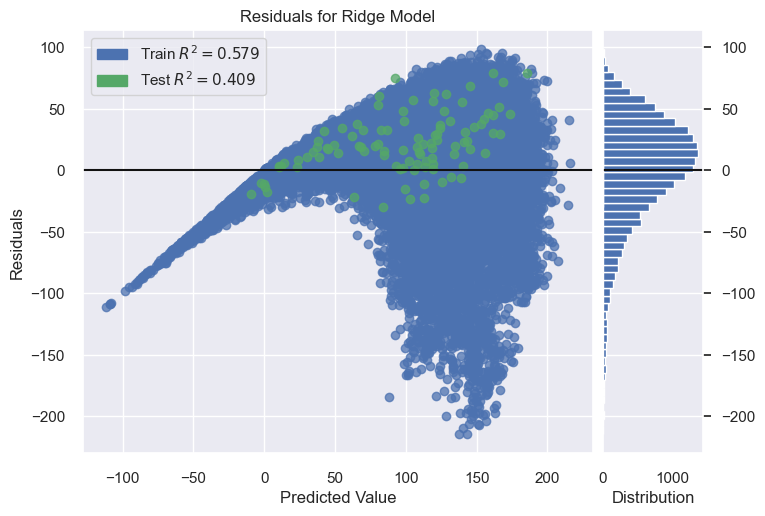

In [33]:
visualizer = ResidualsPlot(ridge_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

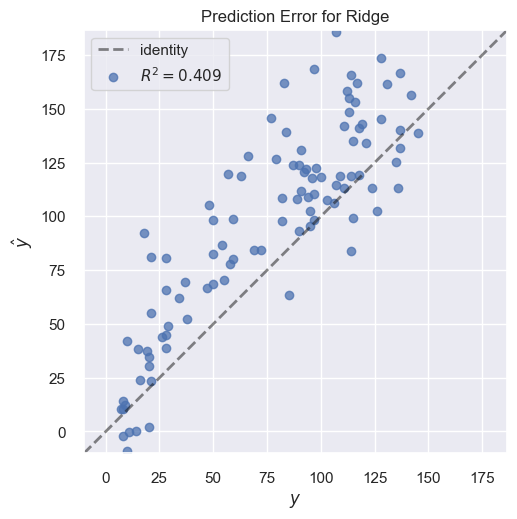

In [34]:
visualizer = PredictionError(ridge_model, bestfit=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();                 # Finalize and render the figure

# ElasticNetCV (L1 and L2 reg)

In [35]:
from warnings import filterwarnings
filterwarnings('ignore')

ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

elastic_cv = ElasticNetCV(l1_ratio=ratios, 
                             alphas=alphas,
                             max_iter = 10,
                             cv=3, 
                             n_jobs=-1, 
                             normalize=True)
elastic_cv.fit(X_train, y_train)

print('alpha: %f' % elastic_cv.alpha_)
print('l1_ratio_: %f' % elastic_cv.l1_ratio_)

alpha: 0.000010
l1_ratio_: 0.850000


In [38]:
elastic_model = ElasticNet(alpha=0.0001, l1_ratio=0.85)
evaluate_train_test(elastic_model, X_train, y_train, X_test, y_test)

Training_performance
RMSE : 44.668274835052294 and R2 : 0.5794470853753801

Testing_performance
RMSE : 31.957862527887638 and R2 : 0.40858013983721464


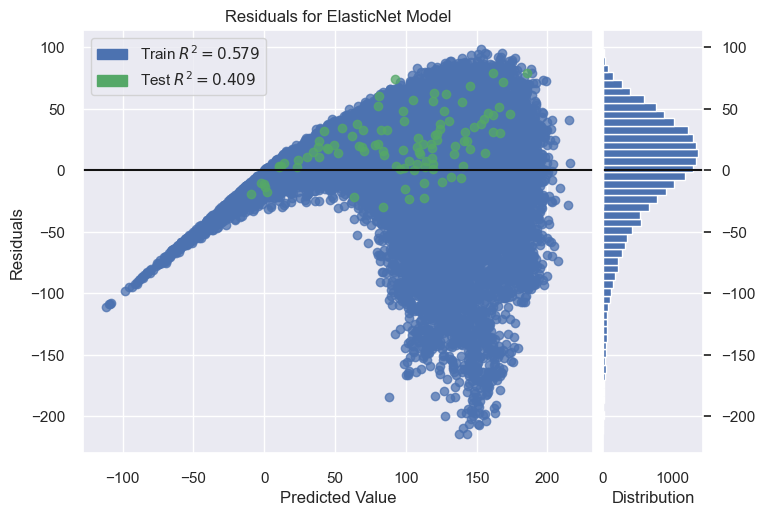

In [39]:
visualizer = ResidualsPlot(elastic_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

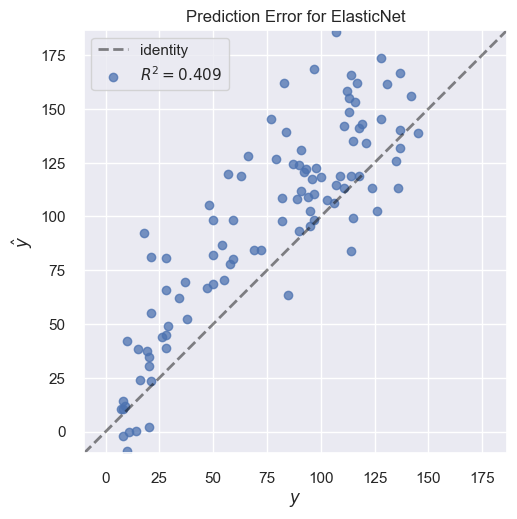

In [40]:
visualizer = PredictionError(elastic_model, bestfit=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();                 # Finalize and render the figure

# Piece-wise RUL

## Linear Regression

In [41]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_clipped)
y_pred = linear_model.predict(X_test)

In [42]:
evaluate_train_test(linear_model, X_train, y_train_clipped, X_test, y_test)

Training_performance
RMSE : 21.491018701515234 and R2 : 0.734043286805049

Testing_performance
RMSE : 21.90021340689233 and R2 : 0.7222608196545781


### Residuals

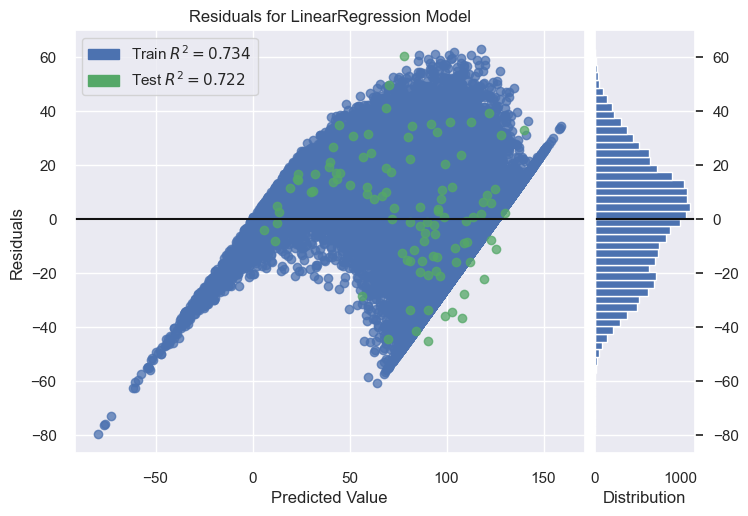

In [43]:
visualizer = ResidualsPlot(linear_model)
visualizer.fit(X_train, y_train_clipped)
visualizer.score(X_test, y_test)
visualizer.show();

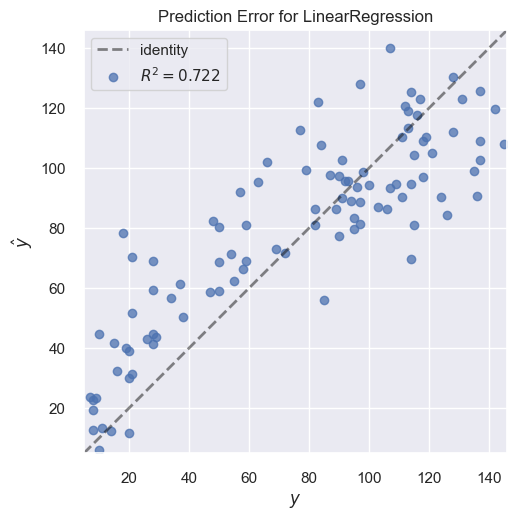

In [44]:
visualizer = PredictionError(linear_model, bestfit=False)

visualizer.fit(X_train, y_train_clipped)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();                 # Finalize and render the figure

### Learning curve

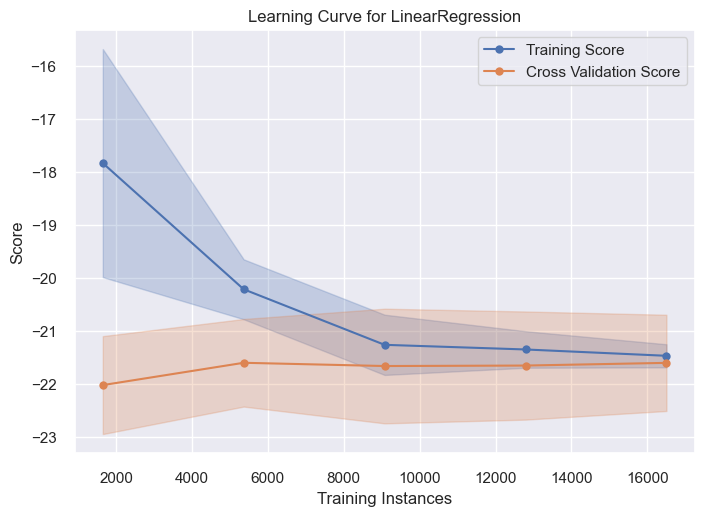

In [45]:
# Instantiate the regression model and visualizer
visualizer = LearningCurve(linear_model, scoring='neg_root_mean_squared_error')

visualizer.fit(X_train, y_train_clipped)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

## ElasticNet

In [46]:
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

elastic_cv = ElasticNetCV(l1_ratio=ratios, 
                             alphas=alphas,
                             max_iter = 10,
                             cv=3, 
                             n_jobs=-1, 
                             normalize=True)
elastic_cv.fit(X_train, y_train_clipped)

print('alpha: %f' % elastic_cv.alpha_)
print('l1_ratio_: %f' % elastic_cv.l1_ratio_)

alpha: 0.000010
l1_ratio_: 0.870000


In [47]:
elastic_model = ElasticNet(alpha=0.0001, l1_ratio=0.87)
evaluate_train_test(elastic_model, X_train, y_train_clipped, X_test, y_test)

Training_performance
RMSE : 21.491091676435424 and R2 : 0.734041480636329

Testing_performance
RMSE : 21.895769761110312 and R2 : 0.7223735171251189


### Residuals

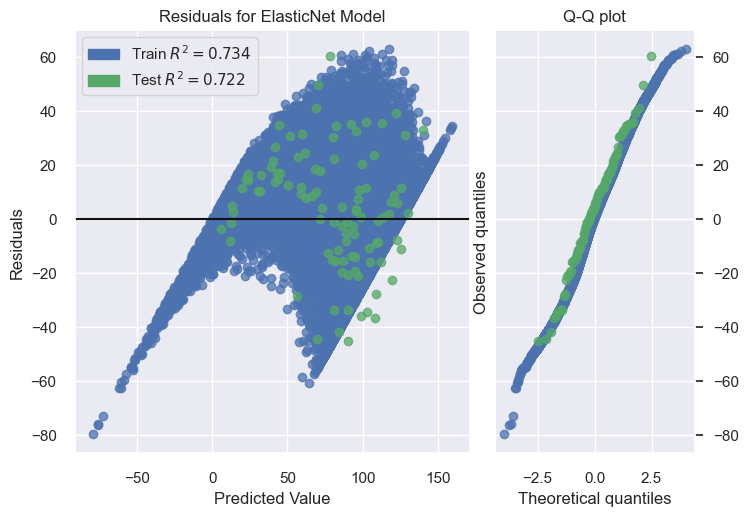

In [48]:
visualizer = ResidualsPlot(elastic_model, hist=False, qqplot=True)
visualizer.fit(X_train, y_train_clipped)
visualizer.score(X_test, y_test)
visualizer.show();

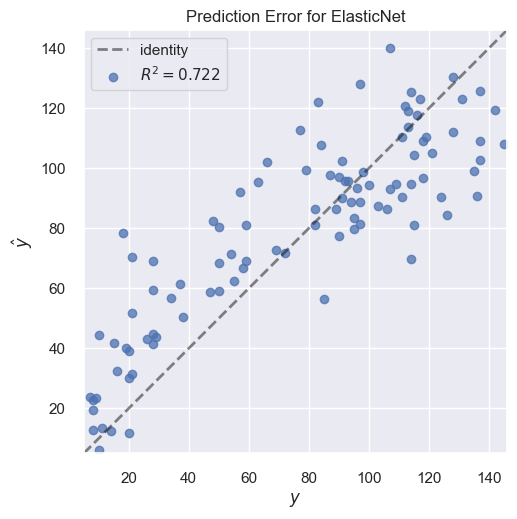

In [49]:
visualizer = PredictionError(elastic_model, bestfit=False)
visualizer.fit(X_train, y_train_clipped)
visualizer.score(X_test, y_test)
visualizer.show();

### Feature selection

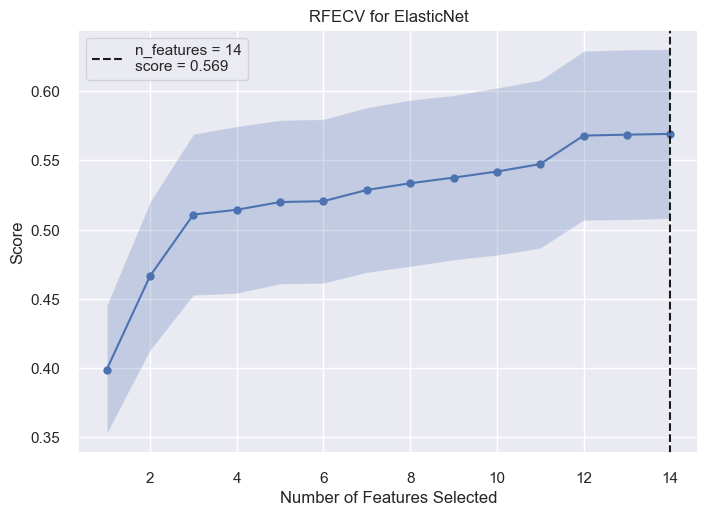

In [50]:
# Instantiate RFECV visualizer with an ElasticNet model
visualizer = RFECV(elastic_model)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

### Learning curve

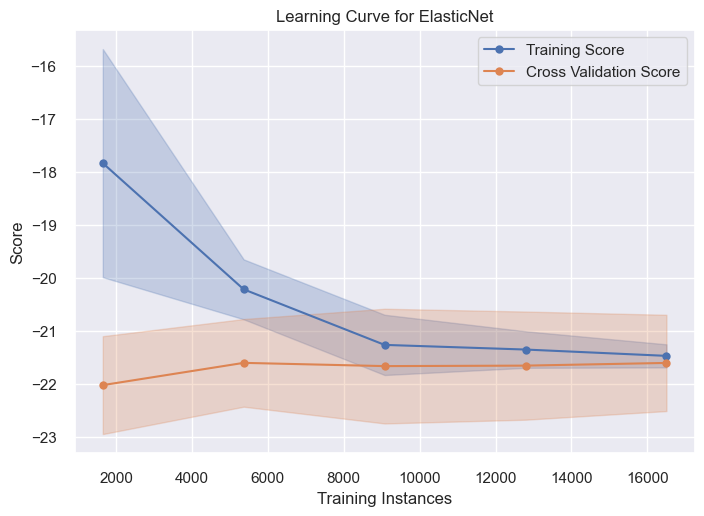

In [51]:
# Instantiate the regression model and visualizer
visualizer = LearningCurve(elastic_model, scoring='neg_root_mean_squared_error')

visualizer.fit(X_train, y_train_clipped)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

In [52]:
visualizer = PredictionError(elastic_model, bestfit=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show(outpath="prediction_error_ElasticNet.png");

## Polynomial Features

### Linear Regression

In [53]:
# Feature engineering
from sklearn.preprocessing import PolynomialFeatures
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train)
X_test_transformed = poly.fit_transform(X_test)

In [54]:
linear_model = LinearRegression()
evaluate_train_test(linear_model, X_train_transformed, y_train_clipped, X_test_transformed, y_test)

Training_performance
RMSE : 19.463815322013026 and R2 : 0.781851162291967

Testing_performance
RMSE : 20.080845881569562 and R2 : 0.7664905495357904


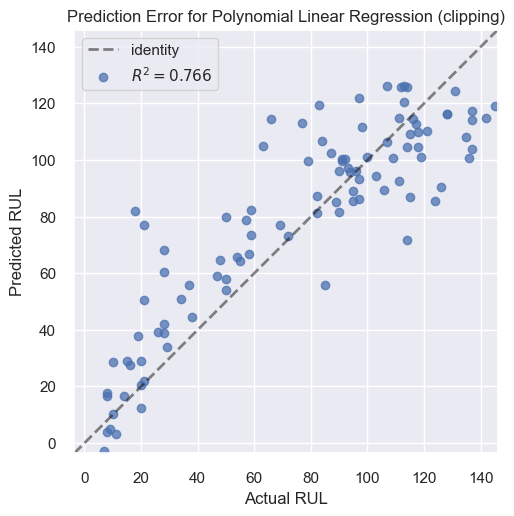

In [56]:
visualiser_pred_error(linear_model, "Polynomial Linear Regression (clipping)", X_train_transformed, y_train, X_test_transformed, y_test, "poly/poly_regression_pred_error.png")

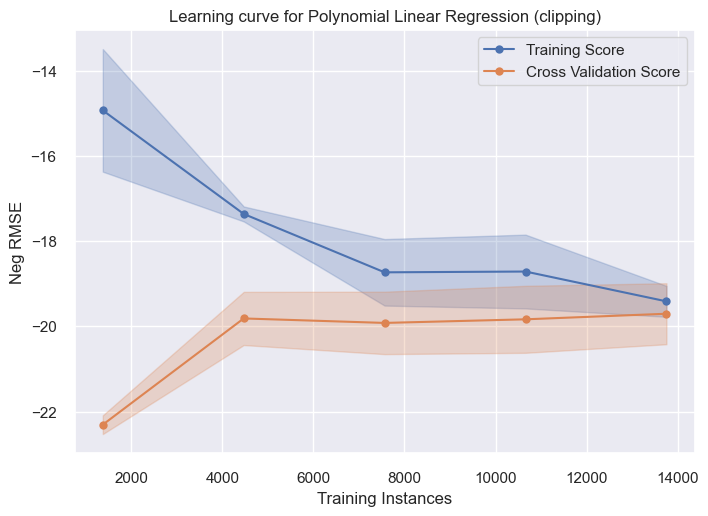

In [57]:
visualiser_learning_curve(linear_model, "Polynomial Linear Regression (clipping)", X_train_transformed, y_train_clipped, 'poly/poly_regression_learning_curve.png')

### ElasticNet

In [58]:
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

elastic_cv = ElasticNetCV(l1_ratio=ratios, 
                             alphas=alphas,
                             max_iter = 1000,
                             cv=3, 
                             n_jobs=-1, 
                             normalize=True)
elastic_cv.fit(X_train_transformed, y_train_clipped)

print('alpha: %f' % elastic_cv.alpha_)
print('l1_ratio_: %f' % elastic_cv.l1_ratio_)

alpha: 0.000000
l1_ratio_: 0.990000


In [59]:
elastic_model = ElasticNet(alpha=0, l1_ratio=0.99)
evaluate_train_test(elastic_model, X_train_transformed, y_train_clipped, X_test_transformed, y_test)

Training_performance
RMSE : 21.232662697098448 and R2 : 0.740399291071902

Testing_performance
RMSE : 21.678765214321995 and R2 : 0.7278492474372718


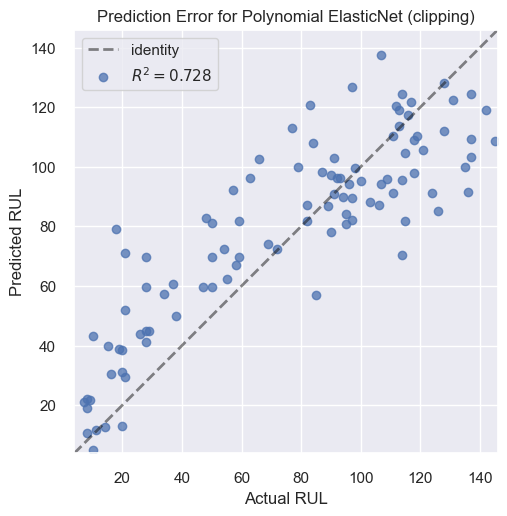

In [61]:
visualiser_pred_error(elastic_model, "Polynomial ElasticNet (clipping)", X_train_transformed, y_train, X_test_transformed, y_test, "poly/poly_elasticnet_pred_error.png")

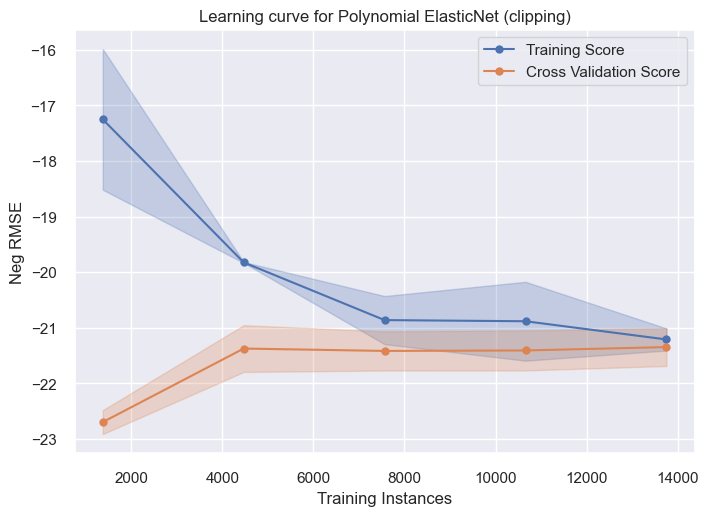

In [62]:
visualiser_learning_curve(elastic_model, "Polynomial ElasticNet (clipping)", X_train_transformed, y_train_clipped, 'poly/poly_elasticnet_learning_curve.png')

# Support Vector Machines

In [ ]:
svr_model = Pipeline([
    ('scaling', MinMaxScaler()),
    ('svr', SVR())
])

## Performances

### No clipping

In [ ]:
evaluate_train_test(svr_model, X_train, y_train, X_test, y_test)

In [ ]:
def learning_curves(estimator, X_train, y_train, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X_train, y_train, train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,40)

In [ ]:
visualiser_learning_curve(svr_model, "SVR (no clipping)", X_train, y_train, 'svr/svr_learning_curve.png')

In [ ]:
visualiser_pred_error(svr_model, "SVR (no clipping)", X_train, y_train, X_test, y_test, "svr/svr_pred_error.png")

In [ ]:
visualizer = ResidualsPlot(svr_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

visualiser.finalize()
visualiser.ax.set_title('Residuals for SVR (no clipping)')

visualizer.show();

### Clipping

In [ ]:
evaluate_train_test(svr_model, X_train, y_train_clipped, X_test, y_test)

## Learning curve

In [ ]:
# Instantiate the regression model and visualizer
visualizer_svr = LearningCurve(svr_model, scoring='neg_root_mean_squared_error')

visualizer_svr.fit(X_train, y_train_clipped)        # Fit the data to the visualizer
visualizer_svr.show(outpath='model_figs/svr/svr_clip_learning_curve.png');           # Finalize and render the figure

In [ ]:
visualizer = PredictionError(svr_model, bestfit=False)

visualizer.fit(X_train, y_train_clipped)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show('model_figs/svr/svr_clip_pred_error.png');                 # Finalize and render the figure

In [ ]:
visualizer = ResidualsPlot(svr_model)
visualizer.fit(X_train, y_train_clipped)
visualizer.score(X_test, y_test)

visualiser.finalize()

visualizer.show();

## Tuning of epsilon

In [ ]:
epsilon = [1, 5, 10, 20, 30, 40]

scaler_svr = MinMaxScaler()

X_train_scaled = scaler_svr.fit_transform(X_train)
X_test_scaled = scaler_svr.transform(X_test)

list_train_rmse = []
list_test_rmse = []
list_train_variance = []
list_test_variance = []

for e in epsilon:
    svr = SVR(kernel='linear', epsilon=e)
    svr_model = Pipeline([('scaling', MinMaxScaler()), ('svr', svr)])
    svr_model.fit(X_train, y_train_clipped)

    # predict and evaluate
    y_hat = svr.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train_clipped, y_hat)
    train_rmse = np.sqrt(train_mse)
    train_variance = r2_score(y_train_clipped, y_hat)
    print('Training')
    print("epsilon:", e, "RMSE:", train_rmse, "R2:", train_variance)
    list_train_rmse.append(train_rmse)
    list_train_variance.append(train_variance)
    
    y_pred_test = svr.predict(X_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_variance = r2_score(y_test, y_pred_test)
    print('Testing')
    print("epsilon:", e, "RMSE:", test_rmse, "R2:", test_variance)
    list_test_rmse.append(test_rmse)
    list_test_variance.append(test_variance)

In [ ]:
plt.plot(epsilon, list_train_rmse, label='Training')
plt.plot(epsilon, list_test_rmse, label='Testing')
plt.legend()
plt.title('Tuning of Epsilon for SVR')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.show();

In [ ]:
epsilon = np.arange(0, 2.1, 0.1)

list_train_rmse = []
list_test_rmse = []
list_train_variance = []
list_test_variance = []

for e in epsilon:
    svr = SVR(kernel='linear', epsilon=e)
    svr_model = Pipeline([('scaling', MinMaxScaler()), ('svr', svr)])
    svr_model.fit(X_train, y_train_clipped)

    # predict and evaluate
    y_hat = svr.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train_clipped, y_hat)
    train_rmse = np.sqrt(train_mse)
    train_variance = r2_score(y_train_clipped, y_hat)
    list_train_rmse.append(train_rmse)
    list_train_variance.append(train_variance)
    
    y_pred_test = svr.predict(X_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_variance = r2_score(y_test, y_pred_test)
    list_test_rmse.append(test_rmse)
    list_test_variance.append(test_variance)
    

In [ ]:
epsilon

In [ ]:
plt.plot(epsilon, list_train_rmse, label='Training')
plt.plot(epsilon, list_test_rmse, label='Testing')
plt.legend()
plt.title('Tuning of Epsilon for SVR')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.show();

## Randomized Search CV

In [ ]:
params_dict = {
    "svr__epsilon": [1, 2, 3, 4, 5],
    "svr__C": [1, 2, 3, 4, 5],
    "svr__kernel": ['linear', 'rbf', 'poly']
}

svr_grid = RandomizedSearchCV(svr_model, params_dict, cv = 3, scoring='neg_root_mean_squared_error')
svr_grid.fit(X_train, y_train_clipped)

svr_grid.best_params_

In [ ]:
svr_grid.best_score_

In [ ]:
pd.DataFrame(svr_grid.cv_results_).sort_values(by='rank_test_score')

In [ ]:
svr_model = SVR(kernel='rbf', epsilon= 3, C= 3)

visualizer = PredictionError(svr_model, bestfit=False)
visualizer.fit(X_train_scaled, y_train_clipped)
visualizer.score(X_test_scaled, y_test)
visualizer.show();

In [ ]:
evaluate_train_test(svr_model, X_train_scaled, y_train_clipped, X_test_scaled, y_test)

In [ ]:
# Instantiate the regression model and visualizer
visualizer_svr = LearningCurve(svr_model, scoring='neg_root_mean_squared_error')

visualizer_svr.fit(X_train_scaled, y_train_clipped)        # Fit the data to the visualizer
visualizer_svr.show();           # Finalize and render the figure